# Import modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/BiconNet/BiconNet')
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/BiconNet/BiconNet')

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
# from GetDataset import MyDataset
import glob
from torchvision import datasets, transforms
from model.unet_model import UNet
# from solver import Solver
import torch.nn.functional as F
import torch.nn as nn
# from GetDataset import MyDataset, connectivity_matrix
# from GetDataset_test import MyDataset_test
import cv2
from skimage.io import imread, imsave


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import sklearn
import cv2

# Open source codes for BiconNet

code source: https://github.com/Zyun-Y/BiconNets

## solver

Edited: Xingqi Su

In [ ]:
from random import shuffle
import numpy as np
from connect_loss import connect_loss
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from lr_update import get_lr
from torch.optim import lr_scheduler

import os
from cldice import clDice
from tensorboardX import SummaryWriter
import torchvision.utils as utils
from skimage.io import imread, imsave

Directable={'upper_left':[-1,-1],'up':[0,-1],'upper_right':[1,-1],'left':[-1,0],'right':[1,0],'lower_left':[-1,1],'down':[0,1],'lower_right':[1,1]}
TL_table = ['lower_right','down','lower_left','right','left','upper_right','up','upper_left']

save = 'save'
if not os.path.isdir(save):
    os.makedirs(save)


def create_exp_directory(exp_id):
    if not os.path.exists('models/'+str(exp_id)):
        os.makedirs('models/'+str(exp_id))


class Solver(object):
    # global optimiser parameters
    default_optim_args = {"lr": 1e-2,
                          "betas": (0.9, 0.999),
                          "eps": 1e-8,
                          "weight_decay": 0.0001}


    def __init__(self, optim=torch.optim.Adam, lr=0.001,
                class_num=1):
        self.lr = lr
        self.optim = optim
        self.loss_func = connect_loss(class_num)

        self.class_num = class_num

        self.hori_trans = torch.zeros([1,self.class_num,256,256]).cuda()
        for i in range(255):
            self.hori_trans[:,:,i,i+1] = torch.tensor(1.0)
        self.verti_trans = torch.zeros([1,self.class_num,256,256]).cuda()
        for j in range(255):
            self.verti_trans[:,:,j,j+1] = torch.tensor(1.0)
        self.hori_trans = self.hori_trans.float()
        self.verti_trans = self.verti_trans.float()



    def train(self, model, train_loader, val_loader, exp_id=0,num_epochs=10):
        
        optim = self.optim(model.parameters(), lr =self.lr)
        # scheduler = lr_scheduler.StepLR(optim, step_size=self.step_size,
        #                                 gamma=self.gamma)  # decay LR by a factor of 0.5 every 5 epochs  

        model.cuda()

        print('START TRAIN.')
        
        create_exp_directory(exp_id)
        
        csv = 'results_'+str(exp_id)+'.csv'
        with open(os.path.join(save, csv), 'w') as f:
            f.write('epoch, dice, Jac \n')

        

 
        best_p = 0

        best_epo = 0
        # self.test_epoch(model,val_loader,1,exp_id)
        
        for epoch in range(num_epochs):

            model.train()
            # scheduler.step()
            curr_lr = get_lr(self.lr,'poly', epoch, num_epochs)

            for param_group in optim.param_groups:
                param_group['lr'] = curr_lr
            print(param_group['lr'])

            for i_batch, sample_batched in enumerate(train_loader):
                X = Variable(sample_batched[0])
                y = Variable(sample_batched[1])
                conn = Variable(sample_batched[2])

                X= X.cuda()

                y = y.cuda()
                conn = conn.cuda()

                optim.zero_grad()

                s_output = model(X)

                
                loss = self.loss_func(s_output, y,conn,self.hori_trans,self.verti_trans)


                loss.backward()
                optim.step()
                
                
                print('[epoch:'+str(epoch)+'][Iteration : ' + str(i_batch) + '/' + str(len(train_loader)) + '] Total:%.3f ' %(
                    loss.item()))


            dice_p = self.test_epoch(model,val_loader,epoch,exp_id)
            
            if best_p<dice_p:
                best_p = dice_p
                best_epo = epoch
                torch.save(model.state_dict(), 'models/' + str(exp_id) + '/best_model.pth')
            # if epoch%5==0:
            #     torch.save(model.state_dict(), 'models/' + str(exp_id) + '/relaynet_epoch' + str(epoch + 1)+'.pth')
        csv = 'results.csv'
        with open(os.path.join(save, csv), 'a') as f:
            f.write('%03d,%0.6f \n' % (
                best_epo,
                best_p
            ))


        print('FINISH.')
        

    def test_epoch(self,model,loader,epoch,exp_id):

            model.eval()
            # cnt = 0
            self.dice_ls = []
            self.Jac_ls=[]
            cldc_ls=[]
            with torch.no_grad(): 
                for j_batch, test_data in enumerate(loader):
                    curr_dice = []
                    X_test = Variable(test_data[0])
                    y_test = Variable(test_data[1])
                    name = test_data[2]
                    
                    X_test= X_test.cuda()

                    y_test = y_test.cuda()

                    output_test = model(X_test)
                    self.hori_translation = self.hori_trans.repeat(X_test.shape[0],1,1,1)
                    self.verti_translation = self.verti_trans.repeat(X_test.shape[0],1,1,1)


                    output_test = F.sigmoid(output_test)
                    pred = torch.where(output_test>0.5,1,0)

                    pred,_ = self.ConMap2Mask_prob(pred)


                    dice,Jac = self.per_class_dice(pred,y_test)
                    
                    pred_np = pred.squeeze().cpu().numpy()
                    target_np = y_test.squeeze().cpu().numpy()
                    cldc = clDice(pred_np,target_np)
                    cldc_ls.append(cldc)
                    self.dice_ls += dice.tolist()
                    self.Jac_ls += Jac.tolist()

                    if j_batch%20==0:
                        print('[Iteration : ' + str(j_batch) + '/' + str(len(loader)) + '] Total DSC:%.3f ' %(
                            np.mean(self.dice_ls)))

                Jac_ls =np.array(self.Jac_ls)
                dice_ls = np.array(self.dice_ls)
                total_dice = np.mean(dice_ls)
                csv = 'results_'+str(exp_id)+'.csv'
                with open(os.path.join(save, csv), 'a') as f:
                    f.write('%03d,%0.6f,%0.6f,%0.6f \n' % (
                        (epoch + 1),
                        total_dice,
                        np.mean(Jac_ls),
                        np.mean(cldc_ls)
                        # np.mean(self.acc_to)
                    ))


                return np.mean(self.dice_ls)

    
    def test_epoch_eval(self,model,loader,epoch,exp_id, total):

        model.eval()
        # cnt = 0
        self.dice_ls = []
        self.Jac_ls=[]
        cldc_ls=[]
        name_ls=[]
        # if exp_id == 1:
        pred_ls = np.zeros((total, 256, 256))
        label_ls = np.zeros((total, 256, 256))
        image_ls = np.zeros((total, 256, 256))
        # elif exp_id == 2:
        #   pred_ls = np.zeros((total, 256, 256))
        #   label_ls = np.zeros((total, 256, 256))
        # else:
        #   pred_ls = np.zeros((total, 256, 256))
        #   label_ls = np.zeros((total, 256, 256))

        print('continue')
        with torch.no_grad(): 
            
            for j_batch, test_data in enumerate(loader):
            # for j_batch, test_data, test_id in enumerate(batch):
                # print(str(j_batch))
                curr_dice = []
                X_test = Variable(test_data[0])
                y_test = Variable(test_data[1])
                name = test_data[2]
                
                X_test= X_test.cuda()

                y_test = y_test.cuda()

                output_test = model(X_test)
                self.hori_translation = self.hori_trans.repeat(X_test.shape[0],1,1,1)
                self.verti_translation = self.verti_trans.repeat(X_test.shape[0],1,1,1)


                output_test = F.sigmoid(output_test)
                pred = torch.where(output_test>0.5,1,0)

                pred,_ = self.ConMap2Mask_prob(pred)



                dice,Jac = self.per_class_dice(pred,y_test)
                X_test_np = X_test.squeeze().cpu().numpy()
                pred_np = pred.squeeze().cpu().numpy()
                # print(pred_np.shape)
                target_np = y_test.squeeze().cpu().numpy()
                cldc = clDice(pred_np,target_np)
                cldc_ls.append(cldc)
                self.dice_ls += dice.tolist()
                self.Jac_ls += Jac.tolist()

                pred_ls[j_batch, ...] = pred_np
                label_ls[j_batch, ...] = target_np
                image_ls[j_batch, ...] = X_test_np
                name_ls.append(name)

               
                if j_batch%20==0:
                    print('[Iteration : ' + str(j_batch) + '/' + str(len(loader)) + '] Total DSC:%.3f ' %(
                        np.mean(self.dice_ls)))
                  # print('Get prediciton in shape:', pred.shape)
            print('Get prediciton in shape:', pred_ls.shape)
            Jac_ls =np.array(self.Jac_ls)
            dice_ls = np.array(self.dice_ls)
            total_dice = np.mean(dice_ls)
            csv = 'results_'+str(exp_id)+'.csv'
            with open(os.path.join(save, csv), 'a') as f:
                f.write('%03d,%0.6f,%0.6f,%0.6f \n' % (
                    (epoch + 1),
                    total_dice,
                    np.mean(Jac_ls),
                    np.mean(cldc_ls)
                    # np.mean(self.acc_to)
                ))
            return np.mean(self.dice_ls), pred_ls, label_ls, image_ls, name_ls



    def per_class_dice(self,y_pred, y_true):

        FN = torch.sum((1-y_pred)*y_true,dim=(1,2,3)) 
        FP = torch.sum((1-y_true)*y_pred,dim=(1,2,3)) 

        inter = torch.sum(y_true* y_pred,dim=(1,2,3)) 

        union = torch.sum(y_true,dim=(1,2,3)) + torch.sum(y_pred,dim=(1,2,3)) 
        Jac = (inter+0.0001)/(inter+FP+FN+0.0001)

        return (2*inter+0.0001)/(union+0.0001),Jac


    def shift_diag(self,img,shift):
        ## shift = [1,1] moving right and down
        # print(img.shape,self.hori_translation.shape)
        batch,class_num, row, column = img.size()
        img = img.float()
        if shift[0]: ###horizontal
            img = torch.bmm(img.view(-1,row,column),self.hori_translation.view(-1,column,column)) if shift[0]==1 else torch.bmm(img.view(-1,row,column),self.hori_translation.transpose(3,2).view(-1,column,column))
        if shift[1]: ###vertical
            img = torch.bmm(self.verti_translation.transpose(3,2).view(-1,row,row),img.view(-1,row,column)) if shift[1]==1 else torch.bmm(self.verti_translation.view(-1,row,row),img.view(-1,row,column))
        return img.view(batch,class_num, row, column)
        
    def ConMap2Mask_prob(self,c_map):
        c_map = c_map.view(c_map.shape[0],self.class_num,8,c_map.shape[2],c_map.shape[3])
        batch,class_num,channel, row, column = c_map.size()


        shifted_c_map = torch.zeros(c_map.size()).cuda()

        for i in range(8):
            shifted_c_map[:,:,i] = self.shift_diag(c_map[:,:,7-i].clone(),Directable[TL_table[i]])
        vote_out = c_map*shifted_c_map
        vote_out = vote_out.float()
        pred_mask,_ = torch.max(vote_out,dim=2)

        return pred_mask,vote_out

    def test_pred(self, model, train_loader, val_loader, exp_id=0,num_epochs=10, total=137):
    
        optim = self.optim(model.parameters(), lr =self.lr)
        # scheduler = lr_scheduler.StepLR(optim, step_size=self.step_size,
        #                                 gamma=self.gamma)  # decay LR by a factor of 0.5 every 5 epochs  

        model.cuda()

        print('START TRAIN.')
        
        create_exp_directory(exp_id)
        
        csv = 'results_'+str(exp_id)+'.csv'
        with open(os.path.join(save, csv), 'w') as f:
            f.write('epoch, dice, Jac \n')

        


        best_p = 0

        best_epo = 0
        mDSC, pred, label, image, name = self.test_epoch_eval(model,val_loader,1,exp_id, total)
        return pred, label, image, name
        # print('FINISH.')

## GetDataset

In [ ]:
# !rm -rf /content/prediction

In [ ]:
# import data
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/original_images.zip
!unzip /content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/combined_masks.zip
image_directory = '/content/original_images'
mask_directory = '/content/combined_masks'

In [ ]:
# code source: https://github.com/Zyun-Y/BiconNets
class Normalize(object):
    def __call__(self, image, mask=None):
        # image = (image - self.mean)/self.std

        image = (image-image.min())/(image.max()-image.min())
        mask = mask/255.0
        if mask is None:
            return image
        return image, mask


def Resize(image, mask,H,W):
    image = cv2.resize(image, dsize=(W, H), interpolation=cv2.INTER_LINEAR)
    if mask is not None:
        mask  = cv2.resize( mask, dsize=(W, H), interpolation=cv2.INTER_LINEAR)
        return image, mask
    else:
        return image

class ToTensor(object):
    def __call__(self, image, mask=None):
        image = torch.from_numpy(image)
        if mask is None:
            return image
        mask  = torch.from_numpy(mask)

        return image, mask

def _resize_image(image, target):
   return cv2.resize(image, dsize=(target[0], target[1]), interpolation=cv2.INTER_LINEAR)


def connectivity_matrix(mask):
    # print(mask.shape)
    [channels,rows, cols] = mask.shape

    conn = torch.ones([8,rows, cols])
    up = torch.zeros([rows, cols])#move the orignal mask to up
    down = torch.zeros([rows, cols])
    left = torch.zeros([rows, cols])
    right = torch.zeros([rows, cols])
    up_left = torch.zeros([rows, cols])
    up_right = torch.zeros([rows, cols])
    down_left = torch.zeros([rows, cols])
    down_right = torch.zeros([rows, cols])


    up[:rows-1, :] = mask[0,1:rows,:]
    down[1:rows,:] = mask[0,0:rows-1,:]
    left[:,:cols-1] = mask[0,:,1:cols]
    right[:,1:cols] = mask[0,:,:cols-1]
    up_left[0:rows-1,0:cols-1] = mask[0,1:rows,1:cols]
    up_right[0:rows-1,1:cols] = mask[0,1:rows,0:cols-1]
    down_left[1:rows,0:cols-1] = mask[0,0:rows-1,1:cols]
    down_right[1:rows,1:cols] = mask[0,0:rows-1,0:cols-1]

    # print(mask.shape,down_right.shape)
    conn[0] = mask[0]*down_right
    conn[1] = mask[0]*down
    conn[2] = mask[0]*down_left
    conn[3] = mask[0]*right
    conn[4] = mask[0]*left
    conn[5] = mask[0]*up_right
    conn[6] = mask[0]*up
    conn[7] = mask[0]*up_left
    conn = conn.float()

    return conn


In [ ]:
import torch.utils.data as data
class MyDataset(data.Dataset):# 
    def __init__(self, train_root, mode='train'): 
        img_path = '/content/original_images/'
        gt_path = '/content/combined_masks/'

        img_ls = []
        mask_ls = []
        name_ls = []

        print(train_root)

        for pat_id in train_root:
            img_l = glob.glob(img_path+pat_id+'*')

            for img in img_l:
                gt = img.split('original_images/')[0]+'combined_masks/'+img.split('original_images/')[1]
                name = img.split('original_images/')[1].split('.bmp')[0]
                img_ls.append(img)
                mask_ls.append(gt)
                name_ls.append(name)

        self.mode = mode
        self.name_ls = name_ls
        self.img_ls = img_ls

        self.mask_ls = mask_ls

        self.normalize  = Normalize()
        # self.randomflip = RandomFlip()

        self.totensor   = ToTensor()

    def __getitem__(self, index):

        img  = cv2.imread(self.img_ls[index],0).astype(np.float32)
        mask  = cv2.imread(self.mask_ls[index], 0).astype(np.float32)
        # print(img.max(),mask.max())

        if self.mode == 'train':
            img, mask = self.normalize(img, mask)
            img, mask = Resize(img, mask,256,256)
            # 
            # img, mask = self.randomflip(img, mask)
            img, mask = self.totensor(img, mask)
            mask = torch.where(mask>0.5,1,0).float()
            img, mask = img.unsqueeze(0), mask.unsqueeze(0)
            conn = connectivity_matrix(mask)
            return img,mask,conn
        else:
            img, mask = self.normalize(img, mask)
            img, mask = Resize(img, mask,256,256)

            img, mask = self.totensor(img, mask)
            mask = torch.where(mask>0.5,1,0).float()
            img, mask = img.unsqueeze(0), mask.unsqueeze(0)
            name = self.name_ls[index]
            return img, mask,name


    def __len__(self):
        return len(self.img_ls)


# Training & get best model


*   UNet-BiconNet
*   Initial learning rate = 6e-4



In [ ]:
#torch.set_default_tensor_type('torch.FloatTensor')
# import minerl
# import gym
torch.cuda.set_device(0)
# gym.logger.set_level(40)


def main():
    subName = ['T0012','T0013','T0014']
    total_pat = [0,1,2]
    
    for exp_id in range(3):
        test_id = [subName[exp_id]]
        # print(test_id)
        train_id = list(set(total_pat)-set([exp_id]))
        train_id = [subName[i] for i in train_id]
        print(train_id)

        train_data = MyDataset(train_root = train_id, mode='train')
        test_data = MyDataset(train_root = test_id, mode='test')
        print("Train size: %i" % len(train_data))
        print("Test size: %i" % len(test_data))


        train_loader = torch.utils.data.DataLoader(train_data,pin_memory=(torch.cuda.is_available()), batch_size=8, shuffle=True, num_workers=8)
        val_loader = torch.utils.data.DataLoader(test_data,pin_memory=(torch.cuda.is_available()), batch_size=1, shuffle=False, num_workers=4)


        student = UNet(1,8).cuda()

        solver = Solver(lr= 0.0006)

        solver.train(student, train_loader, val_loader, exp_id+1, num_epochs=80)

if __name__ == '__main__':
    main()
    

Streaming output truncated to the last 5000 lines.
[epoch:46][Iteration : 23/36] Total:0.015 
[epoch:46][Iteration : 24/36] Total:0.025 
[epoch:46][Iteration : 25/36] Total:0.019 
[epoch:46][Iteration : 26/36] Total:0.015 
[epoch:46][Iteration : 27/36] Total:0.013 
[epoch:46][Iteration : 28/36] Total:0.011 
[epoch:46][Iteration : 29/36] Total:0.021 
[epoch:46][Iteration : 30/36] Total:0.021 
[epoch:46][Iteration : 31/36] Total:0.019 
[epoch:46][Iteration : 32/36] Total:0.038 
[epoch:46][Iteration : 33/36] Total:0.011 
[epoch:46][Iteration : 34/36] Total:0.009 
[epoch:46][Iteration : 35/36] Total:0.015 
[Iteration : 0/139] Total DSC:0.754 
[Iteration : 20/139] Total DSC:0.865 
[Iteration : 40/139] Total DSC:0.846 
[Iteration : 60/139] Total DSC:0.804 
[Iteration : 80/139] Total DSC:0.792 
[Iteration : 100/139] Total DSC:0.772 
[Iteration : 120/139] Total DSC:0.784 
0.0002704162637405345
[epoch:47][Iteration : 0/36] Total:0.013 
[epoch:47][Iteration : 1/36] Total:0.017 
[epoch:47][Iterat

## Save metrics

In [ ]:
# !zip -r models.zip models/ 
!zip -r save.zip save/

  adding: save/ (stored 0%)
  adding: save/results.csv (deflated 10%)
  adding: save/results_1.csv (deflated 63%)
  adding: save/results_2.csv (deflated 63%)
  adding: save/results_3.csv (deflated 63%)


In [ ]:
# !rm -rf /content/combined_masks/

# data prediciton & testing

In [ ]:
def visualize(X_test, y_test, pred, best_var):
    import random
    X_test = X_test[best_var]
    y_test = y_test[best_var]
    pred = pred[best_var]
    test_img_number = random.randint(0, X_test.shape[0])
    print(test_img_number)

    # plt.imshow(prediction[0][12, ...])
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    prediction = pred[test_img_number]

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:], cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(prediction[:,:], cmap='gray')


def savePred(y_p, filenames, exp_id):
    # if type == 'Mask':
      if not os.path.exists('prediction/'+str(exp_id+1)):
        os.makedirs('prediction/'+str(exp_id+1))
      path = 'prediction/'+str(exp_id+1)
      for i in range(len(filenames)):
          cv2.imwrite(os.path.join(path, str(filenames[i][0])+'.bmp'), y_p[i, ...] * 255.0)
      return

In [ ]:
def main():
    subName = ['T0012','T0013','T0014']
    total_pat = [0,1,2]
    prediction = []
    labels = []
    images = []
    names = []
    for exp_id in range(3):
        test_id = [subName[exp_id]]
        # print(test_id)
        train_id = list(set(total_pat)-set([exp_id]))
        train_id = [subName[i] for i in train_id]
        print(train_id)

        train_data = MyDataset(train_root = train_id, mode='train')
        test_data = MyDataset(train_root = test_id, mode='test')
        print("Train size: %i" % len(train_data))
        print("Test size: %i" % len(test_data))
        total = len(test_data)


        train_loader = torch.utils.data.DataLoader(train_data,pin_memory=(torch.cuda.is_available()), batch_size=8, shuffle=True, num_workers=8)
        val_loader = torch.utils.data.DataLoader(test_data,pin_memory=(torch.cuda.is_available()), batch_size=1, shuffle=False, num_workers=4)


        student = UNet(1,8).cuda()

        student.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/BiconNet_TrainedModels/'+str(exp_id+1)+'/best_model.pth'))

        solver = Solver(lr= 0.0006)

        pred, label, image, name = solver.test_pred(student, train_loader, val_loader, exp_id+1, num_epochs=80, total=len(test_data))
        
        print(pred.shape)
        savePred(pred, name, exp_id)

        prediction.append(pred)
        labels.append(label)
        images.append(image)
        names.append(name)

        # plt.imshow(prediction[0][12, ...])
        # plt.imshow(labels[0][12, ...])
        # plt.imshow(images[0][12, ...])
        # visualize(images, labels, prediction, exp_id)


if __name__ == '__main__':
    main()


['T0013', 'T0014']
['T0013', 'T0014']
['T0012']
Train size: 276
Test size: 146
START TRAIN.
continue
[Iteration : 0/146] Total DSC:1.000 
[Iteration : 20/146] Total DSC:0.673 
[Iteration : 40/146] Total DSC:0.688 
[Iteration : 60/146] Total DSC:0.707 
[Iteration : 80/146] Total DSC:0.709 
[Iteration : 100/146] Total DSC:0.704 
[Iteration : 120/146] Total DSC:0.717 
[Iteration : 140/146] Total DSC:0.725 
Get prediciton in shape: (146, 256, 256)
(146, 256, 256)
['T0012', 'T0014']
['T0012', 'T0014']
['T0013']
Train size: 283
Test size: 139
START TRAIN.
continue
[Iteration : 0/139] Total DSC:0.800 
[Iteration : 20/139] Total DSC:0.836 
[Iteration : 40/139] Total DSC:0.814 
[Iteration : 60/139] Total DSC:0.804 
[Iteration : 80/139] Total DSC:0.786 
[Iteration : 100/139] Total DSC:0.783 
[Iteration : 120/139] Total DSC:0.787 
Get prediciton in shape: (139, 256, 256)
(139, 256, 256)
['T0012', 'T0013']
['T0012', 'T0013']
['T0014']
Train size: 285
Test size: 137
START TRAIN.
continue
[Iteration

## Save predictions to local drive

In [ ]:
!zip -r prediction.zip prediction/ 
# !zip -r save.zip save/

## Predicted masks and labels comparison

In [ ]:
SIZE = 256
def getTest(TestSubName, path, name=False):
    # if type == 'Mask':
      dataset = []
      data_name = []
      # print((TestSubName[0]))
      all_images = glob.glob(os.path.join(path, TestSubName[0]+'*'))
      all_images.sort(reverse=False)
      # print(all_images)
      for i, image_name in enumerate(all_images):
      # print(image_name)
        # if image_name.split('.')[1] == 'bmp':
        image = cv2.imread(image_name, 0)
        # print(image)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        data_name.append(image_name.split('.')[0].split('/')[-1])
      # if type == 'Mask':
      dataset = np.expand_dims((np.array(dataset)), 3) / 255.0
      if name:
          return dataset, data_name
      else:
          return dataset

testsub:  ['T0013'] trainSubNames:  ['T0012', 'T0014']
(139, 256, 256, 1)


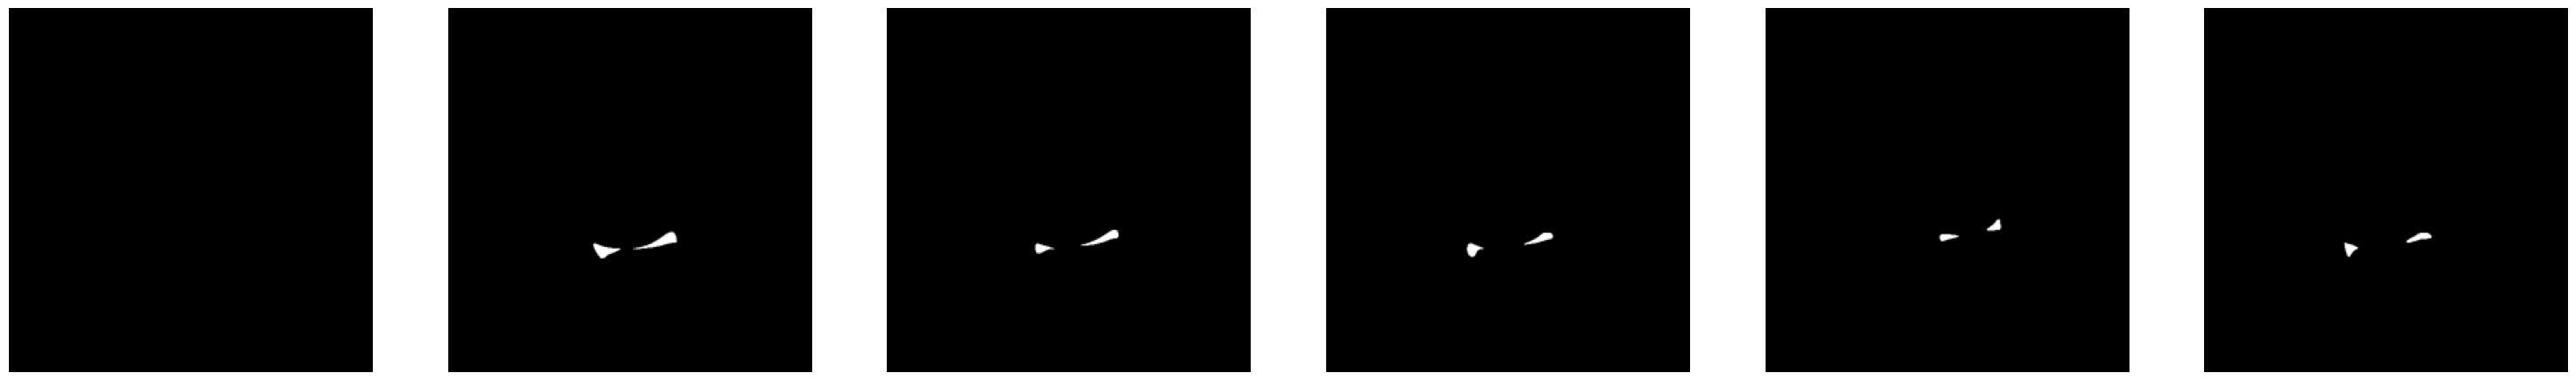

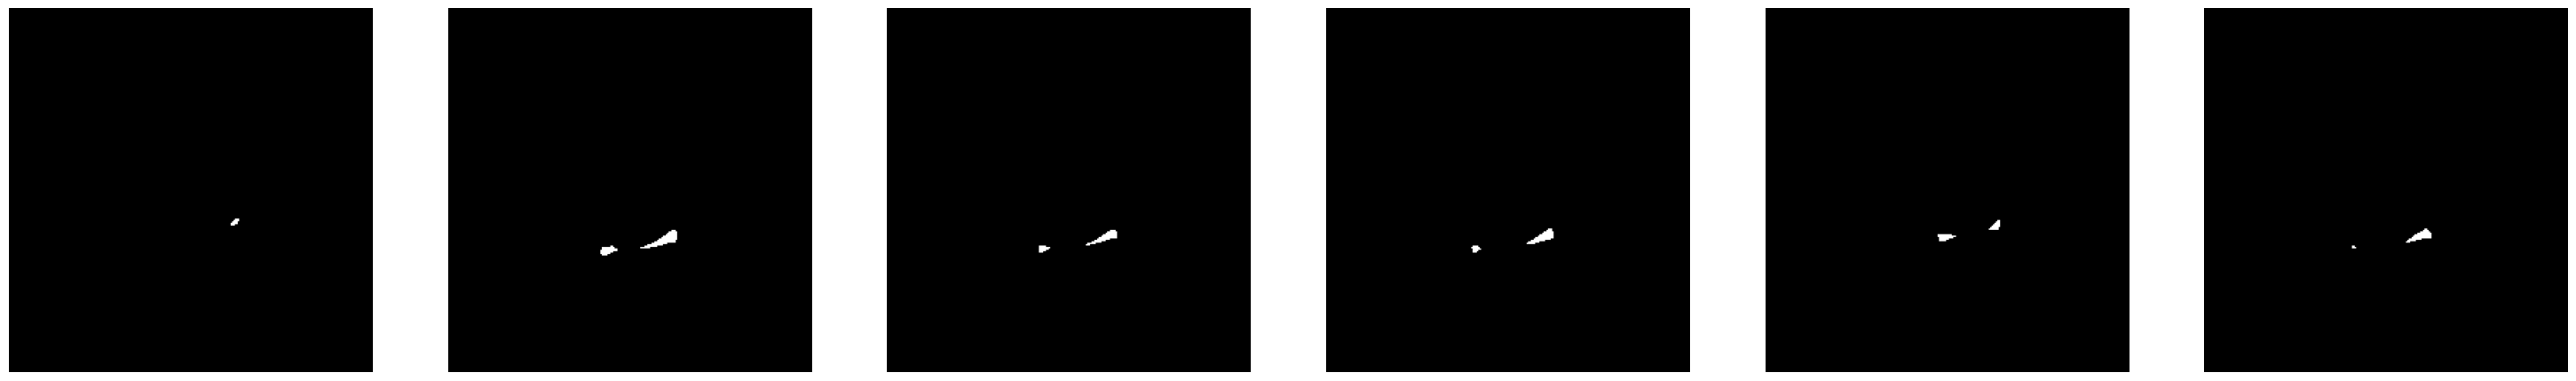

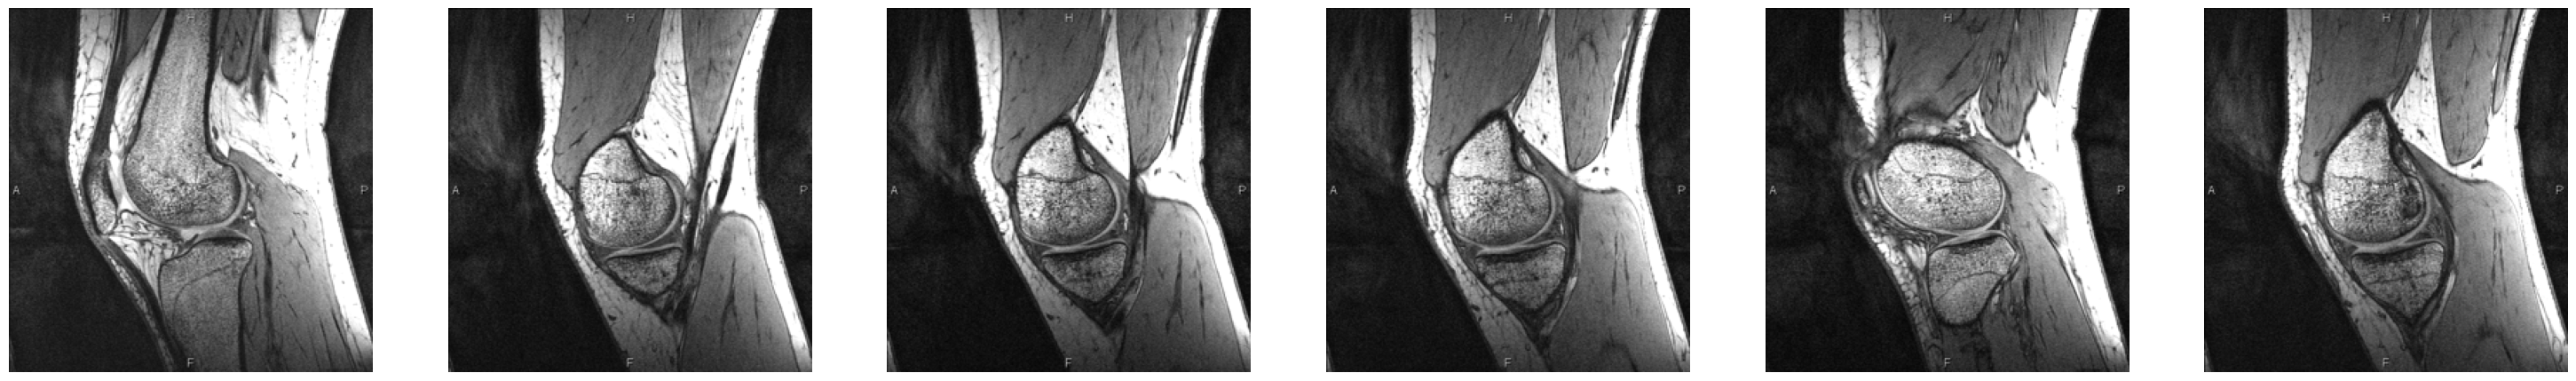

In [ ]:
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
Y = ['T0012', 'T0013', 'T0014']
dice_BN = [0.7280, 0.7946, 0.7650]
accuracy_BN = []
precision_BN = []
sensitivity_BN = []

testSubName = ['T0013']
trainSubName = list(set(Y) - set(testSubName))
print('testsub: ', testSubName, 'trainSubNames: ', trainSubName)
pred_path = '/content/drive/MyDrive/ColabNotebooks/FinalProject/KFold/BiconNet_Prediction/'+str(2)
prediction_BN = getTest(testSubName, pred_path)
x_test_BN = getTest(testSubName, image_directory)
y_test_BN = getTest(testSubName, mask_directory)
print(x_test_BN.shape)


def plot_examples(batch):
    plt.figure(figsize=(50,50))
    for i in range(len(batch)):
        plt.subplot(8, 8, i+1)
        plt.imshow(batch[i])
        gs1 = gridspec.GridSpec(8, 8)
        gs1.update(wspace=0.0025, hspace=0.05)
        plt.axis('off')
        plt.gray()
    plt.show()
    gs1.update(wspace=0.0025, hspace=0.05)

y_test_BN, prediction_BN, x_test_BN = shuffle(y_test_BN, prediction_BN, x_test_BN, random_state=0)
plot_examples(np.sum(y_test_BN[63:69], axis=3)) # display the test images
plot_examples(np.sum(prediction_BN[63:69],axis=3)) # display the test masks
plot_examples(np.sum(x_test_BN[63:69], axis=3)) # display thresholded images